**<div style="text-align: right;">The University of Chicago</div>**
<div style="text-align: right;">MS Financial Mathematics</div>

**<div style="text-align: left;">FINM 35000 - Topics in Economics</div>**
<div style="text-align: left;">Autumn 2024</div>

<h2><center> Data Project 2: Stress Testing an Equity Portfolio </center></h2>

### Team Members

- Antonio Pineda - Worked on Section 4 and 5
- Kaleem Bukhari - Worked on Section 3, 4, and 5
- Raafay Uqaily - Worked on Section 3, 4 and 5
- Yasmine Outtara - Worked on Section 4

### Import Statements

In [1]:
import os
import wrds
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from pathlib import Path
import matplotlib.cm as cm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller, kpss

# Dataframe numeric values display format
pd.options.display.float_format = '{:.6f}'.format

# Ignore warnings
warnings.filterwarnings("ignore")

import os
import wrds
import quandl
import zipfile
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import numpy as np 
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.cm as cm
import datetime as dt
pd.options.display.float_format = '{:.6f}'.format

In [2]:
BASE_DIR = Path(os.getcwd()).resolve()
DATA_DIR = BASE_DIR / "Data"
print(f'Base Directory: \n {BASE_DIR}')
print(f'Data Directory: \n {DATA_DIR}')

Base Directory: 
 /Users/raafayuqaily
Data Directory: 
 /Users/raafayuqaily/Data


### Section 3.1 Portfolio Composition

EW PORTFOLIO WEIGHTS

Our first portfolio is designed to balance sector diversification by equally allocating weights to three primary sectors—Financials, Healthcare, and Consumer Staples. Within each sector, stocks are equally weighted to maintain neutrality and ensure that the portfolio reflects sector-specific dynamics and their overall economic contributions.

EF PORTFOLIO WEIGHTS

Our second portfolio  employs mean-variance optimization to construct an efficient frontier allocation. By leveraging historical return data and the covariance structure of stocks, this portfolio seeks to maximize returns for a given level of risk. This approach prioritizes an optimized balance between risk and reward, favoring stocks with favorable return-risk tradeoffs. Together, these two portfolios provide complementary perspectives—one emphasizing diversification and simplicity, and the other focusing on optimal performance under historical and stress-testing conditions.

In [3]:
stock_data = {
    "STOCK": [
        "ARCHER-DANIELS-MIDLAND CO", "BANK OF AMERICA CORP", "BIOGEN INC", 
        "CITIGROUP INC", "CONAGRA BRANDS INC", "COLGATE-PALMOLIVE CO", 
        "CAMPBELL SOUP CO", "JOHNSON & JOHNSON", "JPMORGAN CHASE & CO", 
        "KELLANOVA", "COCA-COLA CO", "LILLY (ELI) & CO", "MERCK & CO", 
        "MORGAN STANLEY", "PFIZER INC", "PROCTER & GAMBLE CO", 
        "TYSON FOODS INC", "WALMART INC"
    ],
    "SECTOR": [
        "CONSUMER STAPLES", "FINANCIALS", "HEALTHCARE",
        "FINANCIALS", "CONSUMER STAPLES", "CONSUMER STAPLES",
        "CONSUMER STAPLES", "HEALTHCARE", "FINANCIALS",
        "CONSUMER STAPLES", "CONSUMER STAPLES", "HEALTHCARE",
        "HEALTHCARE", "FINANCIALS", "HEALTHCARE",
        "CONSUMER STAPLES", "CONSUMER STAPLES", "CONSUMER STAPLES"
    ]
}

portfolio = pd.DataFrame(stock_data)

sector_counts = portfolio['SECTOR'].value_counts()
sector_weights = {sector: 0.33 / count for sector, count in sector_counts.items()}
portfolio['EW PORTFOLIO WEIGHT'] = portfolio['SECTOR'].map(sector_weights)

portfolio = portfolio[["SECTOR", "STOCK", "EW PORTFOLIO WEIGHT"]]
portfolio = portfolio.sort_values(by="SECTOR")
portfolio = portfolio.reset_index(drop=True)

ef_weights_dict = {
    "ARCHER-DANIELS-MIDLAND CO": 0.0681024,
    "BANK OF AMERICA CORP": 0,
    "BIOGEN INC": 0.0835473,
    "CITIGROUP INC": 0,
    "CONAGRA BRANDS INC": 0,
    "COLGATE-PALMOLIVE CO": 0.0405726,
    "CAMPBELL SOUP CO": 0,
    "JOHNSON & JOHNSON": 0.0299107,
    "JPMORGAN CHASE & CO": 0.1521091,
    "KELLANOVA": 0.0084220,
    "COCA-COLA CO": 0,
    "LILLY (ELI) & CO": 0.2352803,
    "MERCK & CO": 0,
    "MORGAN STANLEY": 0,
    "PFIZER INC": 0,
    "PROCTER & GAMBLE CO": 0.2342193,
    "TYSON FOODS INC": 0.0060473,
    "WALMART INC": 0.1417890
}

portfolio["EF PORTFOLIO WEIGHTS"] = portfolio["STOCK"].map(ef_weights_dict)

portfolio

,SECTOR,STOCK,EW PORTFOLIO WEIGHT,EF PORTFOLIO WEIGHTS
0,CONSUMER STAPLES,ARCHER-DANIELS-MIDLAND CO,0.036667,0.068102
1,CONSUMER STAPLES,PROCTER & GAMBLE CO,0.036667,0.234219
2,CONSUMER STAPLES,COCA-COLA CO,0.036667,0.000000
3,CONSUMER STAPLES,KELLANOVA,0.036667,0.008422
4,CONSUMER STAPLES,TYSON FOODS INC,0.036667,0.006047
5,CONSUMER STAPLES,CAMPBELL SOUP CO,0.036667,0.000000
6,CONSUMER STAPLES,WALMART INC,0.036667,0.141789
7,CONSUMER STAPLES,CONAGRA BRANDS INC,0.036667,0.000000
8,CONSUMER STAPLES,COLGATE-PALMOLIVE CO,0.036667,0.040573
9,FINANCIALS,CITIGROUP INC,0.082500,0.000000


## Reading Data Files

In [4]:
wrds_file_ = "wrds_data.xlsx"
historic_mev_file_ = "2024-Table_2A_Historic_Domestic.csv"
baseline_mev_file_ = "2024-Table_3A_Supervisory_Baseline_Domestic.csv"
severe_mev_file_ = "2024-Table_4A_Supervisory_Severely_Adverse_Domestic.csv"

wrds_data = pd.read_excel(DATA_DIR/wrds_file_, sheet_name="returns", usecols="A:AB")
historic_mev_data = pd.read_csv(DATA_DIR/historic_mev_file_)
baseline_mev_data = pd.read_csv(DATA_DIR/baseline_mev_file_)
severe_mev_data = pd.read_csv(DATA_DIR/severe_mev_file_,)

In [5]:
portfolio_returns = wrds_data.iloc[:, :-3]

columns_to_drop = [portfolio_returns.columns[-2], portfolio_returns.columns[-4]]
portfolio_returns = portfolio_returns.drop(columns=columns_to_drop)

portfolio_returns['Date'] = pd.to_datetime(portfolio_returns['Date'])
portfolio_returns.set_index('Date', inplace=True)

portfolio_returns = portfolio_returns.drop(columns=['KRAFT HEINZ CO', 'GOLDMAN SACHS GROUP INC'])
portfolio_returns.columns.values[-4] = "TYSON FOODS INC"
portfolio_returns = portfolio_returns.dropna()

weights = dict(zip(portfolio["STOCK"], portfolio["EW PORTFOLIO WEIGHT"]))

portfolio_returns["EW Portfolio Returns"] = portfolio_returns[list(weights.keys())].mul(list(weights.values()), axis=1).sum(axis=1)

In [6]:
# Define the mean-variance optimization function
def mean_variance_optimization(returns, risk_free_rate):
    n = returns.shape[1]
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    # Objective function: Maximize Sharpe ratio (equivalent to minimizing negative Sharpe ratio)
    def negative_sharpe_ratio(weights):
        portfolio_return = weights @ mean_returns
        portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(portfolio_return - risk_free_rate.mean()) / portfolio_volatility

    # Constraint: Weights sum to 1
    constraints = [{"type": "eq", "fun": lambda weights: np.sum(weights) - 1}]
    
    # Bounds for weights: No short-selling
    bounds = [(0, 1) for _ in range(n)]
    
    # Initial guess (equal weights)
    initial_weights = np.ones(n) / n
    
    # Optimization
    result = minimize(negative_sharpe_ratio, initial_weights, bounds=bounds, constraints=constraints)
    return result.x

stock_returns = portfolio_returns.iloc[:, 0:18]
risk_free_rate = portfolio_returns.iloc[:, 19]

ef_weights = mean_variance_optimization(stock_returns, risk_free_rate)

portfolio_returns["EF Portfolio Returns"] = stock_returns.mul(ef_weights, axis=1).sum(axis=1)
portfolio_returns.head()

,ARCHER-DANIELS-MIDLAND CO,BANK OF AMERICA CORP,BIOGEN INC,CITIGROUP INC,CONAGRA BRANDS INC,COLGATE-PALMOLIVE CO,CAMPBELL SOUP CO,JOHNSON & JOHNSON,JPMORGAN CHASE & CO,KELLANOVA,...,MERCK & CO,MORGAN STANLEY,PFIZER INC,PROCTER & GAMBLE CO,TYSON FOODS INC,WALMART INC,S&P RETURN,RISK-FREE RATE,EW Portfolio Returns,EF Portfolio Returns
Date,,,,,,,,,,,,,,,,,,,,,
1991-10-01,0.068300,0.049100,-0.013300,0.028200,-0.081100,-0.025700,0.033800,0.076400,-0.024600,-0.063400,...,0.054800,0.081300,0.099800,-0.008800,0.038500,-0.031400,0.011900,0.004200,0.021688,-0.014267
1991-11-01,0.000900,-0.080300,-0.351400,-0.103100,0.069500,0.012000,0.003200,0.017300,-0.146500,0.059700,...,0.066500,-0.016200,-0.068700,-0.031400,-0.073600,0.056800,-0.043900,0.003900,-0.048011,-0.058620
1991-12-01,0.210000,0.192600,0.083300,0.206900,0.176800,0.156800,0.095000,0.188100,0.020100,0.222000,...,0.141800,0.197200,0.265500,0.159000,0.073300,0.205500,0.111600,0.003800,0.158020,0.137019
1992-01-01,-0.101900,0.080000,0.192300,0.057100,-0.059600,-0.030400,-0.107600,-0.061100,0.317600,-0.131900,...,-0.056300,-0.110000,-0.131000,0.110500,-0.099400,-0.084900,-0.019900,0.003400,0.001297,0.053472
1992-02-01,-0.011800,0.082600,-0.096800,0.000000,-0.161700,0.000000,-0.006600,-0.054400,0.200900,0.009300,...,0.003200,-0.008900,0.025600,-0.020500,0.014300,0.002300,0.009600,0.002800,0.007296,0.005448


In [7]:
weights_df = pd.DataFrame({
    "Stock Name": stock_returns.columns,
    "EF Weights": ef_weights
})

In [8]:
final_portfolio_returns = portfolio_returns[["EW Portfolio Returns", "EF Portfolio Returns", "RISK-FREE RATE"]]
final_portfolio_returns.to_csv("final_portfolio_returns.csv", index=True)

---

### Section 3.2 Portfolio Data Processing

We can start processing data by first looking at the number of missing data points for each of the 20 stock returns given in the wrds_data excel file. 

In [9]:
returns_data = wrds_data.iloc[:, 1:-7]

missing_returns_data_count = returns_data.isna().sum()
returns_data_start_date = returns_data.apply(lambda col: col.first_valid_index())

missing_data = pd.DataFrame({
    "Missing Returns Data Count": missing_returns_data_count,
    "Start Date": returns_data_start_date
})

missing_data

,Missing Returns Data Count,Start Date
ARCHER-DANIELS-MIDLAND CO,15,15
BANK OF AMERICA CORP,0,0
BIOGEN INC,345,345
CITIGROUP INC,286,286
CONAGRA BRANDS INC,61,61
COLGATE-PALMOLIVE CO,0,0
CAMPBELL SOUP CO,0,0
GOLDMAN SACHS GROUP INC,437,437
JOHNSON & JOHNSON,0,0
JPMORGAN CHASE & CO,0,0


As shown above, 9 out of the 20 stocks have at least some missing data. Since the project requires at least 15 stocks in the portfolio and we would ideally want to maximize our data points for developing a robust prediction model, we chose to eliminate 'KRAFT HEINZ CO' and 'GOLDMAN SACHS GROUP INC' from consideration. This will enable us to use complete returns data from October 1991 to December 2023 without having to use forward filling, back filling, or interpolation techniques to fill in missing values.

Although we have addressed missing data concerns for our specific dataset as described above, here are some generic methods we could apply in different scenarios:

1. Missing Data for Sub-Portfolios or Prediction Models - Sparse missing values in individual stock returns can be imputed to maintain consistency across observations using several approaches like:
- **Forward or Backward Filling**: Filling missing values with the most recent or subsequent available return for that stock.
- **Mean Imputation**: Replacing missing values with the average return of that stock across the dataset.
- **Industry or Sector-Based Imputation**: Replacing missing values with the average return of other stocks in the same industry or sector for that period.

2. Excessive Missing Data - Stocks with a high proportion of missing data may be entirely excluded to avoid introducing excessive noise or bias. Forwardfilling or backfilling may not be appropriate here, especially if companies are listed at different times, because doing so would introduce unrealistic data points. To address this concern, sub-portfolios can be constructed on the basis of listing date. 

Additionally, there are several strategies one can use to group stocks into sub-portfolios based on meaningful classifications to create more targeted predictive models.

Example groupings:
- **Industry-Based Clustering**: Group stocks by sectors like Consumer Staples, Financials, Healthcare, etc.
- **Market Cap-Based Clustering**: Divide stocks into large-cap, mid-cap, and small-cap categories.
- **Volatility-Based Clustering**: Group stocks with similar historical volatility or beta values.

Furthermore, below are some pros and cons for different types of portfolio models that can be used.

#### Sub-Portfolio Models:
**Pros**:
- Simplifies the problem by reducing the number of predictive models.
- Sub-portfolios can capture shared characteristics (e.g., sector trends or macroeconomic sensitivities).

**Cons**:
- Loss of granularity, as individual stock-specific patterns are averaged out.
- Requires careful selection of grouping criteria to avoid introducing bias.

#### Individual Stock Models:
**Pros**:
- Captures unique return dynamics of each stock.
- Allows for high precision in prediction if data is sufficient.

**Cons**:
- Computationally intensive for large portfolios.
- Performance may degrade if stocks have sparse or inconsistent data.

#### Single Portfolio-Wide Model:
**Pros**:
- Simplifies computation by treating the portfolio as a single entity.
- Reduces the need for imputation or clustering decisions.

**Cons**:
- Ignores individual stock or group-level differences.
- May perform poorly if the portfolio is highly heterogeneous.

---

### Section 3.3 Portfolio Data Sources

For the scope of this project, no external data sources beyond the files provided were used.

<b> Note: </b> <I>The date columns in all Macroeconomic Variables files were modified using Microsoft Excel before running the analysis.</I>

1. **WRDS Data** (`wrds_data.xlsx`)
   - File contains monthly returns for 20 different listed stocks, S&P500, Fama-French factors, and risk-free rate starting from 1963.
   - For Fama French 6 Factors models, we used WRDS api to download data for the period of analysis.

2. **Historic Domestic MEVs** (`2024-Table_2A_Historic_Domestic.csv`)
   - File contains historical values of several macroeconomic variables ranging from 1976 to 2023.

3. **Supervisory Baseline Scenario** (`2024-Table_3A_Supervisory_Baseline_Domestic.csv`)
   - File contains projected values of several macroeconomic variables under baseline economic conditions from 2024 to 2027.

4. **Supervisory Severely Adverse Scenario** (`2024-Table_4A_Supervisory_Severely_Adverse_Domestic.csv`)
   - File contains projected values of several macroeconomic variables under a severely adverse economic conditions from 2024 to 2027.

---

### Section 3.4 MEV Stationarity Testing

Before running stationarity tests on the MEV's, we plotted the time series graphs for all variables to see if we could visually determine any variables with exponential growth or multiplicative trends for potential log transformations instead of simply taking the first difference. 

In [10]:
historic_mev_data.head()

,Scenario Name,Date,Real GDP growth,Nominal GDP growth,Real disposable income growth,Nominal disposable income growth,Unemployment rate,CPI inflation rate,3-month Treasury rate,5-year Treasury yield,10-year Treasury yield,BBB corporate yield,Mortgage rate,Prime rate,Dow Jones Total Stock Market Index (Level),House Price Index (Level),Commercial Real Estate Price Index (Level),Market Volatility Index (Level)
0,Actual,1976-03-31,9.300000,14.000000,5.000000,9.600000,7.700000,4.700000,4.900000,7.400000,7.600000,NaN,8.900000,6.800000,NaN,22.900000,50.900000,NaN
1,Actual,1976-06-30,3.000000,7.200000,2.300000,5.800000,7.600000,3.600000,5.200000,7.400000,7.600000,NaN,8.800000,6.900000,NaN,23.600000,51.800000,NaN
2,Actual,1976-09-30,2.200000,7.600000,3.200000,9.600000,7.700000,6.500000,5.200000,7.300000,7.600000,NaN,9.000000,7.100000,NaN,24.200000,52.600000,NaN
3,Actual,1976-12-31,2.900000,10.500000,2.600000,9.200000,7.800000,5.900000,4.700000,6.500000,7.100000,NaN,8.800000,6.500000,NaN,25.200000,53.400000,NaN
4,Actual,1977-03-31,4.800000,11.700000,0.900000,8.400000,7.500000,7.500000,4.600000,6.800000,7.200000,NaN,8.700000,6.300000,NaN,26.200000,55.000000,NaN


#### Data pre-processing and plotting macroeconomic variables 

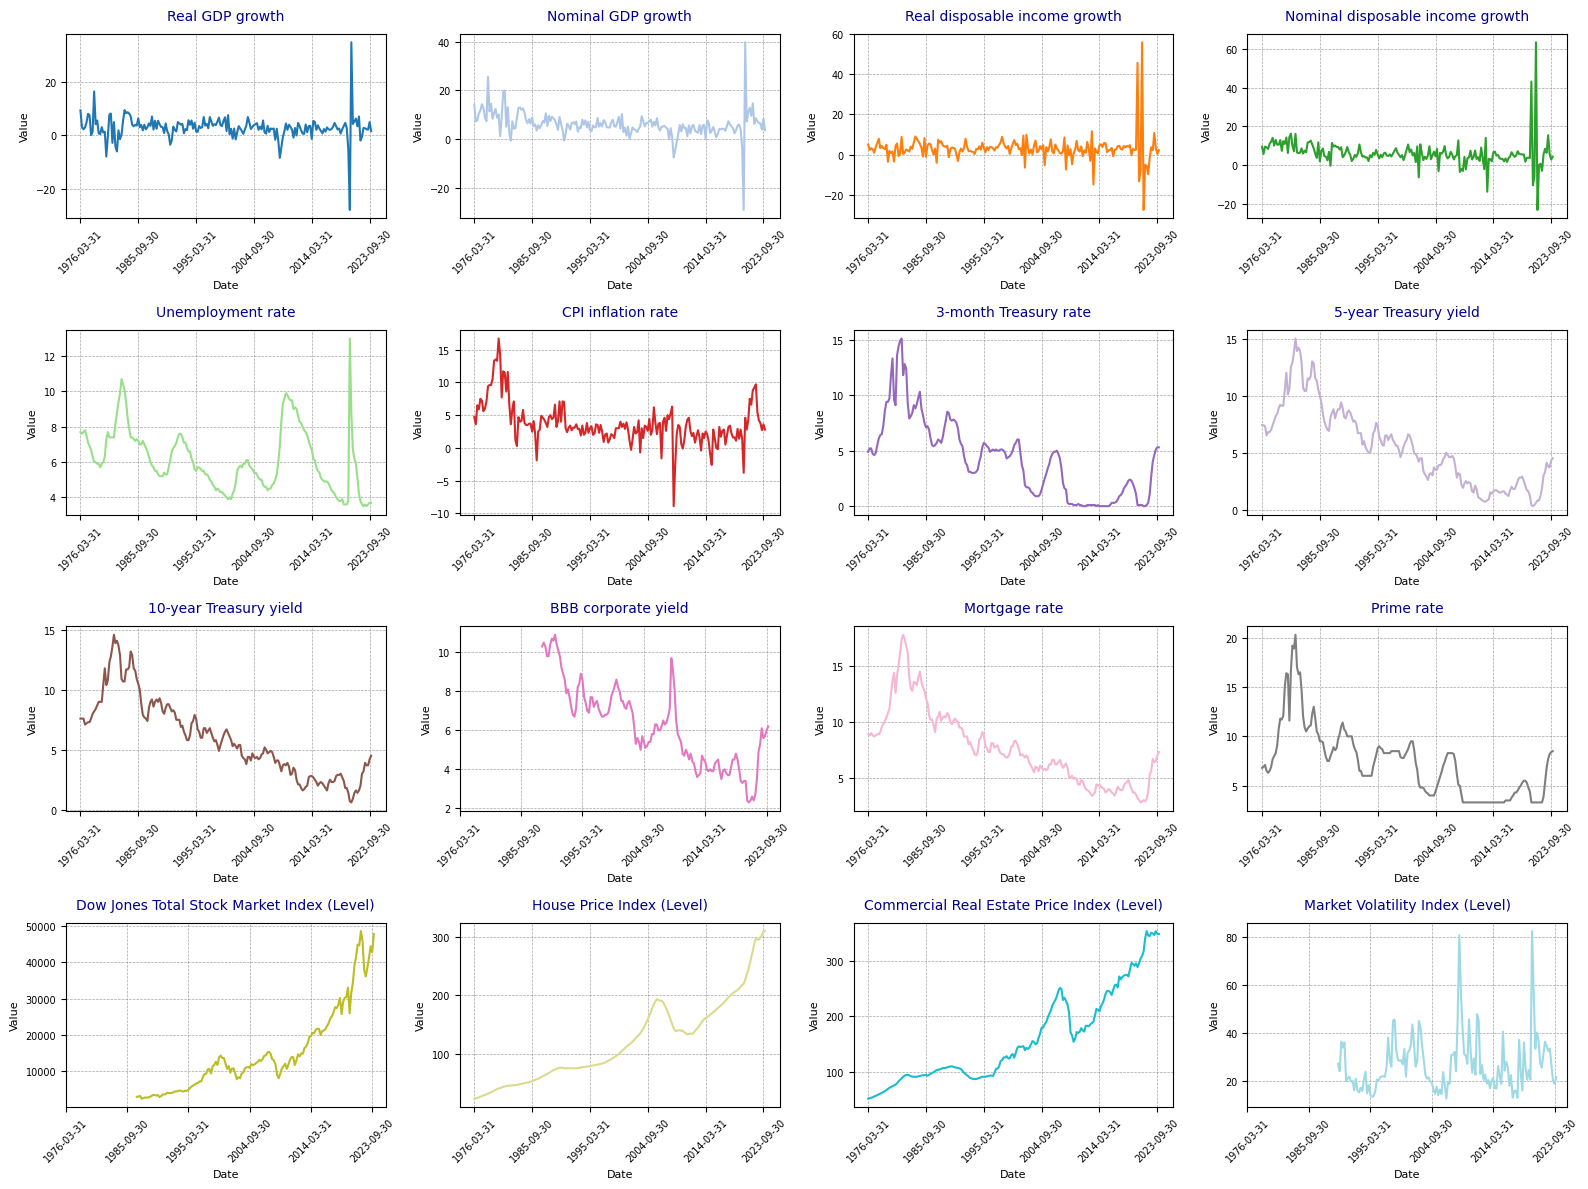

In [11]:
historic_mev_data = historic_mev_data.drop(columns=['Scenario Name'])
historic_mev_data.set_index('Date', inplace=True)

plt.figure(figsize=(16, 12))

columns_to_check = historic_mev_data.columns
colors = cm.tab20(np.linspace(0, 1, len(columns_to_check)))  

n_cols = 4  
n_rows = int(np.ceil(len(columns_to_check) / n_cols))  

for i, (column, color) in enumerate(zip(columns_to_check, colors)):
    plt.subplot(n_rows, n_cols, i + 1)

    plt.plot(historic_mev_data.index, historic_mev_data[column], color=color, linewidth=1.5)

    plt.title(column, fontsize=10, color="darkblue", pad=10)
    plt.xlabel('Date', fontsize=8)
    plt.ylabel('Value', fontsize=8)

    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.xticks(historic_mev_data.index[::len(historic_mev_data) // 5], rotation=45, fontsize=7)
    plt.yticks(fontsize=7)

plt.tight_layout()
plt.show()

Based on the graphs above, Dow Jones Total Stock Market Index (Level), House Price Index (Level) and Commercial Real Estate Price Index (Level) displace exponential growth and may need to undergo log transformation before differencing.

The code below run the ADF Stationarity test for each MEV. If an MEV is Stationary, it is unchanged. However, if an MEV is Non-Stationary, we take first order difference and re-run the ADF Stationary test.

It is important to note that Dow Jones Total Stock Market Index (Level), House Price Index (Level) and Commercial Real Estate Price Index (Level) were log-transformed before running the Stationary test.

In [12]:
def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    adf_stat = result[0]
    p_value = result[1]
    is_stationary = p_value < 0.05  # Stationary if p-value < 0.05
    return {"ADF Statistic": adf_stat, "p-value": p_value, "Stationary": is_stationary}

log_columns = [
    "Dow Jones Total Stock Market Index (Level)", 
    "House Price Index (Level)", 
    "Commercial Real Estate Price Index (Level)"
]

transformed_data = historic_mev_data.copy()

pre_transformation_results = {}

for col in log_columns:
    if col in transformed_data.columns:
        transformed_data[col] = np.log(transformed_data[col])
        print(f"Log transformation applied to {col}.")

for col in historic_mev_data.columns:
    pre_transformation_results[col] = adf_test(historic_mev_data[col])

for col in transformed_data.columns:
    adf_result = adf_test(transformed_data[col])
    if not adf_result["Stationary"]:
        transformed_data[col] = transformed_data[col].diff()
        transformed_data.rename(columns={col: f"{col}_diff"}, inplace=True)
        print(f"First differencing applied to {col} (non-stationary). Renamed to {col}_diff.")

post_transformation_results = {}
for col in transformed_data.columns:
    post_transformation_results[col] = adf_test(transformed_data[col])

pre_results_df = pd.DataFrame(pre_transformation_results).T
post_results_df = pd.DataFrame(post_transformation_results).T

pre_results_df.columns = ["ADF Statistic", "p-value", "Stationary"]
post_results_df.columns = ["ADF Statistic", "p-value", "Stationary"]

transformed_data.dropna(inplace=True)

Log transformation applied to Dow Jones Total Stock Market Index (Level).
Log transformation applied to House Price Index (Level).
Log transformation applied to Commercial Real Estate Price Index (Level).
First differencing applied to Nominal disposable income growth (non-stationary). Renamed to Nominal disposable income growth_diff.
First differencing applied to CPI inflation rate (non-stationary). Renamed to CPI inflation rate_diff.
First differencing applied to 3-month Treasury rate (non-stationary). Renamed to 3-month Treasury rate_diff.
First differencing applied to 5-year Treasury yield (non-stationary). Renamed to 5-year Treasury yield_diff.
First differencing applied to 10-year Treasury yield (non-stationary). Renamed to 10-year Treasury yield_diff.
First differencing applied to BBB corporate yield (non-stationary). Renamed to BBB corporate yield_diff.
First differencing applied to Mortgage rate (non-stationary). Renamed to Mortgage rate_diff.
First differencing applied to Prim

In [13]:
print("\nPre-Transformation Stationarity Test Results:")
pre_results_df


Pre-Transformation Stationarity Test Results:


,ADF Statistic,p-value,Stationary
Real GDP growth,-14.448466,0.000000,True
Nominal GDP growth,-5.559878,0.000002,True
Real disposable income growth,-4.603655,0.000127,True
Nominal disposable income growth,-2.555859,0.102468,False
Unemployment rate,-3.197076,0.020155,True
CPI inflation rate,-2.678369,0.077857,False
3-month Treasury rate,-1.726001,0.417768,False
5-year Treasury yield,-1.096647,0.716407,False
10-year Treasury yield,-0.975310,0.762163,False
BBB corporate yield,-2.466043,0.123956,False


In [14]:
print("\nPost-Transformation Stationarity Test Results:")
post_results_df


Post-Transformation Stationarity Test Results:


,ADF Statistic,p-value,Stationary
Real GDP growth,-14.448466,0.000000,True
Nominal GDP growth,-5.559878,0.000002,True
Real disposable income growth,-4.603655,0.000127,True
Nominal disposable income growth_diff,-6.564533,0.000000,True
Unemployment rate,-3.197076,0.020155,True
CPI inflation rate_diff,-9.957711,0.000000,True
3-month Treasury rate_diff,-5.218654,0.000008,True
5-year Treasury yield_diff,-6.099950,0.000000,True
10-year Treasury yield_diff,-6.028654,0.000000,True
BBB corporate yield_diff,-8.817603,0.000000,True


The stationarity testing and transformations applied to the macroeconomic variables (MEVs) showed mixed results across growth rates, interest rates, and index levels. Key growth rates such as Real GDP growth, Nominal GDP growth, and Real disposable income growth were found to be stationary, requiring no transformation. However, most rates (e.g., CPI inflation rate, 3-month Treasury rate, and 10-year Treasury yield) were non-stationary and required first differencing to remove trends and achieve stationarity. These rates typically exhibit linear trends over time, which are effectively addressed by differencing.

Log transformations were applied to pre-specified variables exhibiting exponential growth, such as the Dow Jones Total Stock Market Index, House Price Index, and Commercial Real Estate Price Index. These transformations stabilized variance and linearized exponential trends. For these variables, first differencing was subsequently applied to ensure full stationarity. The Market Volatility Index, while a level variable, was found to be inherently stationary and did not require any transformation.

In summary, the analysis involved a methodical application of log transformations for variables with exponential growth and first differencing for variables with linear trends. Post-transformation stationarity testing confirmed that all variables are now stationary, meeting the prerequisites for additional modeling and predictive analysis. 

---

### Section 3.5 Summary Statistics

#### Summary Statistics for Stock Portfolio

In [15]:
portfolio_returns_statistics = portfolio_returns.describe()
portfolio_returns_statistics = portfolio_returns_statistics.T
portfolio_returns_statistics

,count,mean,std,min,25%,50%,75%,max
ARCHER-DANIELS-MIDLAND CO,387.000000,0.009435,0.077287,-0.268100,-0.035600,0.007600,0.055850,0.327100
BANK OF AMERICA CORP,387.000000,0.011250,0.103860,-0.532700,-0.039900,0.010000,0.067450,0.729100
BIOGEN INC,387.000000,0.022445,0.150643,-0.405000,-0.052550,0.010000,0.091350,0.838400
CITIGROUP INC,387.000000,0.009937,0.113029,-0.577500,-0.050150,0.009900,0.068550,0.686700
CONAGRA BRANDS INC,387.000000,0.007281,0.068620,-0.339500,-0.032650,0.010300,0.047100,0.221900
COLGATE-PALMOLIVE CO,387.000000,0.010493,0.059448,-0.218200,-0.020050,0.011000,0.041200,0.325800
CAMPBELL SOUP CO,387.000000,0.006352,0.060736,-0.181600,-0.028400,0.010600,0.045300,0.205100
JOHNSON & JOHNSON,387.000000,0.010261,0.053249,-0.160100,-0.024600,0.010900,0.041650,0.188100
JPMORGAN CHASE & CO,387.000000,0.014097,0.087634,-0.305800,-0.033200,0.014500,0.064550,0.325700
KELLANOVA,387.000000,0.006054,0.056636,-0.213000,-0.025850,0.007800,0.038150,0.262700


In [16]:
pr_min_date = portfolio_returns.index.min()
pr_max_date = portfolio_returns.index.max()

print(f"Minimum date in portfolio_returns: {pr_min_date}")
print(f"Maximum date in portfolio_returns: {pr_max_date}")

Minimum date in portfolio_returns: 1991-10-01 00:00:00
Maximum date in portfolio_returns: 2023-12-01 00:00:00


#### Summary Statistics for Transformed (Stationary) MEVs

In [17]:
mev_summary_statistics = transformed_data.describe()
mev_summary_statistics = mev_summary_statistics.T
mev_summary_statistics

,count,mean,std,min,25%,50%,75%,max
Real GDP growth,136.000000,2.541912,4.532672,-28.000000,1.475000,2.550000,4.025000,34.800000
Nominal GDP growth,136.000000,4.873529,5.098456,-29.200000,3.600000,5.000000,6.500000,39.700000
Real disposable income growth,136.000000,2.811029,7.538795,-27.600000,1.200000,2.750000,4.225000,56.000000
Nominal disposable income growth_diff,136.000000,-0.017647,12.432013,-86.600000,-1.925000,0.200000,2.000000,69.300000
Unemployment rate,136.000000,5.758088,1.742946,3.500000,4.475000,5.400000,6.700000,13.000000
CPI inflation rate_diff,136.000000,-0.009559,2.423462,-15.200000,-1.200000,0.000000,1.025000,8.400000
3-month Treasury rate_diff,136.000000,-0.017647,0.426334,-1.300000,-0.100000,0.000000,0.200000,1.600000
5-year Treasury yield_diff,136.000000,-0.025735,0.415977,-1.100000,-0.300000,0.000000,0.200000,1.200000
10-year Treasury yield_diff,136.000000,-0.025735,0.368178,-0.900000,-0.300000,0.000000,0.200000,1.000000
BBB corporate yield_diff,136.000000,-0.026471,0.484613,-1.600000,-0.300000,0.000000,0.225000,2.600000


In [18]:
mev_min_date = transformed_data.index.min()
mev_max_date = transformed_data.index.max()

print(f"Minimum date in portfolio_returns: {mev_min_date}")
print(f"Maximum date in portfolio_returns: {mev_max_date}")

Minimum date in portfolio_returns: 1990-03-31
Maximum date in portfolio_returns: 2023-12-31


The summary statistics reveal key insights into portfolio performance and macroeconomic variables (MEVs). The EF Portfolio Returns, with a mean of 1.26%, outperform the EW Portfolio Returns, which have a mean of 1.12%. The EF Portfolio also exhibits lower volatility, with a standard deviation of 4.22% compared to 4.77% for the EW Portfolio. This demonstrates the effectiveness of mean-variance optimization in achieving higher risk-adjusted returns. 

Most MEVs have reasonable ranges, reflecting both economic expansions and contractions over the covered time period. For instance, Real GDP growth and Nominal GDP growth show mean values of approximately 2.54% and 4.88%, respectively, which align with typical economic growth rates over long periods. However, these variables also show significant variability, with minimum values of -28% and -29.2%, reflecting severe economic downturns such as recessions or crises. The maximum growth rates, particularly for Nominal GDP at 39.7%, may reflect periods of rapid expansion or high inflation.

The Unemployment rate exhibits relatively stable variability, with a mean of 5.76% and a standard deviation of 1.75%. Its range (3.5% to 13%) captures historical lows during economic booms and peaks during periods of unemployment surges, such as recessions. In financial indicators, Treasury yields (3-month, 5-year, and 10-year) and corporate yields exhibit close-to-zero mean values, reflecting long periods of low interest rate changes. 

Overall, these statistics highlight the diversity and volatility inherent in macroeconomic and financial indicators. The wide variability in certain metrics underscores the importance of robust statistical modeling to capture the dynamics and mitigate the impact of outliers in stress-testing scenarios. 

#### Risk Analysis on Selected Portfolio Returns

In [19]:
def summary_statistics(returns, annual_factor=12):
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    summary_statistics['VaR (0.05)'] = returns.quantile(.05, axis=0)
    summary_statistics['CVaR (0.05)'] = returns[returns <= returns.quantile(.05, axis=0)].mean()
    return summary_statistics

portfolio_summary_stats = summary_statistics(final_portfolio_returns)
portfolio_summary_stats

,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05)
EW Portfolio Returns,0.134273,0.165445,0.811591,-0.178845,0.193205,-0.140060,1.773425,-0.065524,-0.096565
EF Portfolio Returns,0.150923,0.147609,1.022451,-0.125704,0.189101,0.033717,0.715608,-0.055699,-0.078318
RISK-FREE RATE,0.023383,0.005979,3.911154,0.000000,0.005600,0.294935,-1.418841,0.000000,0.000000


The comparison between the Equally Weighted (EW) Portfolio Returns and Efficient Frontier (EF) Portfolio Returns reveals that the EF Portfolio outperforms the EW Portfolio on multiple dimensions. The EF Portfolio achieves a higher mean return of 0.1509 compared to 0.1343 for the EW Portfolio while exhibiting lower volatility (0.1476 vs. 0.1654). This results in a superior Sharpe ratio for the EF Portfolio (1.0225 vs. 0.8116), indicating better risk-adjusted performance. The EF Portfolio's improved performance stems from its optimized allocation, which balances returns and risk more effectively than an equally weighted approach.

From a risk perspective, the EF Portfolio demonstrates lower downside risk as measured by Value at Risk (VaR) at the 5% level (-0.0557 vs. -0.0655 for EW) and Conditional Value at Risk (CVaR) (-0.0783 vs. -0.0966 for EW). Additionally, the EF Portfolio exhibits near-zero skewness (0.0337) compared to the slight negative skewness of the EW Portfolio (-0.1401), suggesting a more symmetric return distribution. The lower excess kurtosis of the EF Portfolio (0.7156 vs. 1.7734) further indicates reduced likelihood of extreme return events. These metrics underscore the EF Portfolio's ability to deliver more consistent and stable returns while effectively mitigating extreme downside risks.

#### Risk Analysis on Sector Returns

In [20]:
stock_to_sector = dict(zip(portfolio["STOCK"], portfolio["SECTOR"]))

sector_returns_data = {}

for sector in portfolio["SECTOR"].unique():
    stocks_in_sector = [stock for stock, sec in stock_to_sector.items() if sec == sector]
    sector_returns_data[sector] = portfolio_returns[stocks_in_sector].mean(axis=1)

sector_returns = pd.DataFrame(sector_returns_data)

sector_summary_stats = summary_statistics(sector_returns)
sector_summary_stats

,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05)
CONSUMER STAPLES,0.102995,0.138015,0.746256,-0.130356,0.161689,-0.105897,1.613104,-0.056732,-0.083036
FINANCIALS,0.147525,0.303660,0.485823,-0.314500,0.436075,-0.076826,2.427108,-0.134728,-0.193088
HEALTHCARE,0.156370,0.198502,0.787749,-0.148240,0.278520,0.310017,0.981961,-0.077614,-0.102548


The sector-level returns analysis highlights notable differences in performance and risk across the three sectors. Healthcare exhibits the highest mean return (15.64%) with moderate volatility (19.85%) and the strongest Sharpe ratio (0.788), indicating superior risk-adjusted performance. Financials, while delivering a slightly lower mean return (14.75%), demonstrates significantly higher volatility (30.37%), resulting in the lowest Sharpe ratio (0.486). Consumer Staples, on the other hand, show the lowest mean return (10.30%) and volatility (13.80%), with a moderate Sharpe ratio (0.746), reflecting stability but limited growth potential. The skewness and kurtosis metrics suggest more symmetric return distributions for Financials and Consumer Staples, whereas Healthcare shows mild positive skewness. The Value at Risk (VaR) and Conditional Value at Risk (CVaR) measures reinforce that Healthcare has relatively moderate downside risk, while Financials are the most exposed to extreme negative outcomes. Overall, Healthcare emerges as the most resilient sector, combining strong returns with manageable risk.

#### Plotting cumulative returns for Sectors, Portfolio, S&P 500, Risk Free Rate

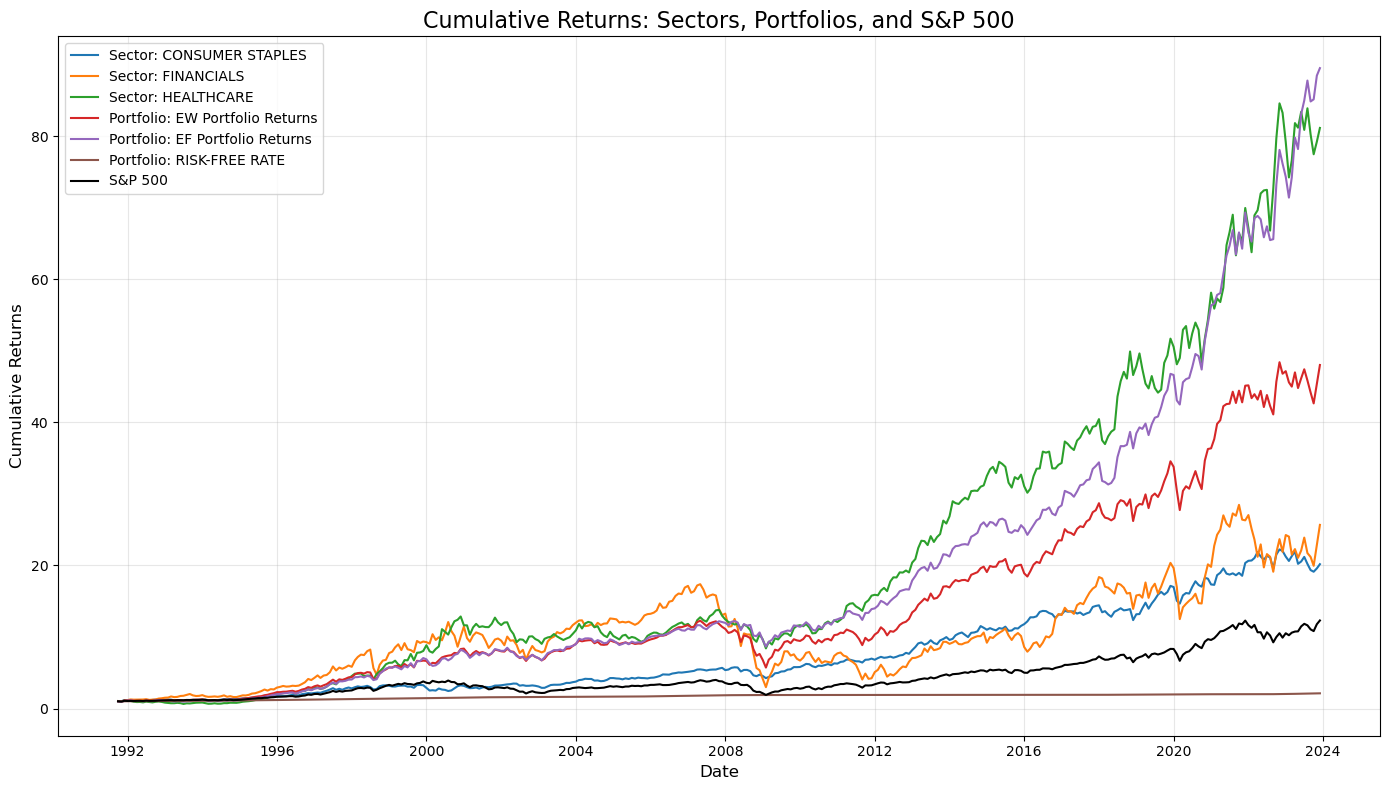

In [21]:
cumulative_sector_returns = (1 + sector_returns).cumprod()
cumulative_portfolio_returns = (1 + final_portfolio_returns).cumprod()
cumulative_sp500_returns = (1 + portfolio_returns["S&P RETURN"]).cumprod()

plt.figure(figsize=(14, 8))

for column in cumulative_sector_returns.columns:
    plt.plot(cumulative_sector_returns.index, cumulative_sector_returns[column], label=f"Sector: {column}")

for column in cumulative_portfolio_returns.columns:
    plt.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns[column], label=f"Portfolio: {column}")

plt.plot(cumulative_sp500_returns.index, cumulative_sp500_returns, label="S&P 500", color="black")

plt.title("Cumulative Returns: Sectors, Portfolios, and S&P 500", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.legend(fontsize=10, loc="upper left")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The cumulative returns plot shows that the Healthcare sector consistently outperforms other sectors and portfolios over time, reflecting its resilience and strong growth potential. The EF Portfolio Returns closely track the performance of the Healthcare sector, suggesting its optimized allocation leans toward higher-performing assets. In contrast, the EW Portfolio Returns and the S&P 500 demonstrate more moderate cumulative growth, with the S&P 500 lagging behind all sectors and portfolios, indicative of its broader market exposure and diversification.

---

### Section 4.1 MEV Selection

#### MEV Correlation Matrix Plot

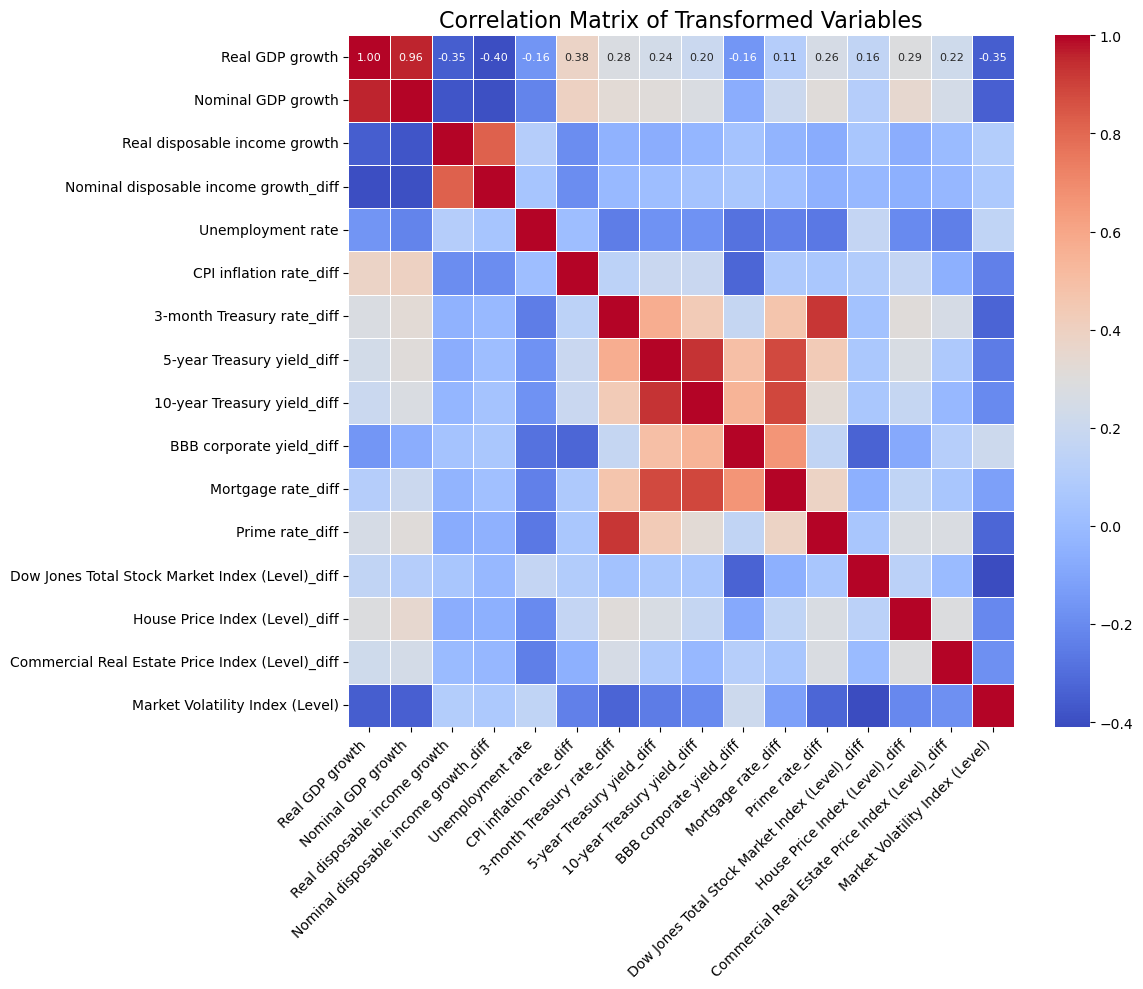

In [22]:
numeric_columns = transformed_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

correlation_matrix = transformed_data[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            cbar=True, annot_kws={"size": 8},  linewidths=0.5)

plt.title('Correlation Matrix of Transformed Variables', fontsize=16)
plt.xticks(fontsize=10, rotation=45, ha="right")
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

The correlation matrix shows strong positive correlations between Real GDP growth and Nominal GDP growth (0.96), as expected, since nominal GDP is an inflation-adjusted measure of real economic output. Treasury rates across different maturities (e.g., 3-month, 5-year, and 10-year yields) also exhibit high correlations, reflecting their shared sensitivity to monetary policy and economic conditions. Additionally, Mortgage rates and Prime rates are closely correlated with Treasury yields, indicating their dependence on broader interest rate movements. These clusters highlight the interdependence of interest rate variables and their collective influence on financial markets.

On the other hand, weaker or negative correlations emerge between growth indicators and financial market indices, such as the Dow Jones Total Stock Market Index and Market Volatility Index, suggesting that stock market performance is less directly tied to short-term economic growth rates. Interestingly, the Market Volatility Index shows relatively low correlations with most variables, emphasizing its distinct behavior during periods of market stress. Overall, the matrix underscores key relationships among economic indicators and financial variables, providing a foundation for selecting meaningful predictors in stress-testing and forecasting models.

#### Selecting shortlisted MEVs for Analysis

In [23]:
selected_mevs_columns = ["Market Volatility Index (Level)", "Unemployment rate", "CPI inflation rate_diff", 
                        "Real GDP growth", "3-month Treasury rate_diff", "10-year Treasury yield_diff"]

selected_mev_data = transformed_data[selected_mevs_columns]
selected_mev_data.head()

,Market Volatility Index (Level),Unemployment rate,CPI inflation rate_diff,Real GDP growth,3-month Treasury rate_diff,10-year Treasury yield_diff
Date,,,,,,
1990-03-31,27.300000,5.300000,3.000000,4.400000,0.100000,0.500000
1990-06-30,24.200000,5.300000,-3.100000,1.500000,-0.100000,0.300000
1990-09-30,36.500000,5.700000,3.100000,0.300000,-0.200000,0.000000
1990-12-31,34.000000,6.100000,-0.100000,-3.600000,-0.500000,-0.300000
1991-03-31,36.200000,6.600000,-4.000000,-1.900000,-1.000000,-0.300000


#### Rationale for selecting Macroeconomic Variables

<b>1. Market Volatility Index (Level)</b>

 - Purpose: This index measures market risk, uncertainty, and investors' sentiments. It spikes during times of financial distress or market turbulence.
 - Relevance in Stress Testing: It acts as a gauge for the overall risk environment in the financial markets. High values typically correlate with lower market prices and increased investor fear, making it crucial for assessing risk under stress scenarios.

<b>2. Unemployment Rate</b>
 
 - Purpose: The unemployment rate is a lagging indicator that provides insights into the health of the labor market. Changes in the unemployment rate are closely tied to economic activity and consumer confidence.
 - Relevance in Stress Testing: It helps evaluate the resilience of the economy in face of adverse events. Higher unemployment may lead to lower consumer spending and could be a precursor to recession, affecting the performance of investments and loan defaults.

<b>3. CPI Inflation Rate</b>

 - Purpose: The Consumer Price Index (CPI) measures the average change over time in the prices paid by urban consumers for a market basket of consumer goods and services. It's a direct measure of purchasing power and price stability.
 - Relevance in Stress Testing: Inflation impacts interest rates, currency values, and overall economic policies. Understanding how scenarios affect inflation helps in forecasting cost of living adjustments, wage growth demands, and policy shifts.

<b>4. Real GDP Growth</b>

 - Purpose: GDP growth measures the economic activity and health of the economy, reflecting the total output of goods and services.
 - Relevance in Stress Testing: It’s essential for assessing the potential growth or contraction in the economy under different scenarios. A decline in GDP growth could signal a recession, affecting investment portfolios, corporate earnings, and employment rates.

<b>5. 3-month Treasury Rate</b>
 
 - Purpose: Short-term Treasury rates are influenced by the Federal Reserve's policies and are indicative of the short-term borrowing costs.
 - Relevance in Stress Testing: The 3-month Treasury rate is a benchmark for many other rates, including bank loan rates and mortgages.

<b>6. 10-year Treasury Rate</b>
 
 - Purpose: Long-term Treasury rates are influenced by the Federal Reserve's policies and are indicative of the long-term borrowing costs.
 - Relevance in Stress Testing: hanges in this rate can influence the entire financial system, affecting liquidity, borrowing costs, and economic growth.

#### Integrating These Variables in Stress Testing

By incorporating these variables, a stress test can comprehensively evaluate how different sectors of the economy and financial markets would behave under various hypothetical adverse scenarios. Here’s how they integrate:

 - <b>Risk Assessment:</b> The Volatility Index and Treasury rates can highlight shifts in risk appetite and funding costs.
 - <b>Economic Impact:</b> GDP and unemployment provide a direct view of economic resilience or weakness.
 - <b>Consumer Impact:</b> CPI gives insight into the consumer side, affecting consumption patterns and retail sales.

Each variable covers a different facet of economic and market dynamics, ensuring that the stress tests can uncover potential vulnerabilities and help in making informed decisions to mitigate those risks.

### Section 4.2 Fama-French 3 Factor Model Regression

The Fama-French three-factor model is formulated as follows:

$$
r_{i,t} - r_{f,t} = \alpha_i + \beta_{i,M} (Rm_t - Rf_t) + \beta_{i,SMB} SMB_t + \beta_{i,HML} HML_t + \epsilon_{i,t}
$$

In [24]:
fama_french_factors_columns = ["Date","FAMA-FRENCH MARKET FACTOR", "FAMA-FRENCH SIZE FACTOR (SMB)", 
                                "FAMA-FRENCH VALUE FACTOR (HML)", "S&P RETURN"]

fama_french_factors = wrds_data[fama_french_factors_columns].copy()

fama_french_factors['Date'] = pd.to_datetime(fama_french_factors['Date'])
fama_french_factors = fama_french_factors[fama_french_factors["Date"] >= "1991-10-01"]
fama_french_factors = fama_french_factors.reset_index(drop=True)
fama_french_factors.set_index('Date', inplace=True)

fama_french_factors = fama_french_factors.rename(columns={'FAMA-FRENCH MARKET FACTOR': 'MARKET FACTOR (Rm-Rf)',
                                                            'FAMA-FRENCH SIZE FACTOR (SMB)': 'SMB','FAMA-FRENCH VALUE FACTOR (HML)': 'HML',
                                                            'S&P RETURN': 'S&P 500 RETURN'})

It is important to note that before running our regressions, we need to convert our portfolio returns data into excess returns. For this, we will subtract the risk free rate from the portfolio returns.

In [25]:
excess_final_portfolio_returns = final_portfolio_returns.copy()

excess_final_portfolio_returns["EW Portfolio Returns Excess"] = (
    excess_final_portfolio_returns["EW Portfolio Returns"] - 
    excess_final_portfolio_returns["RISK-FREE RATE"]
)

excess_final_portfolio_returns["EF Portfolio Returns Excess"] = (
    excess_final_portfolio_returns["EF Portfolio Returns"] - 
    excess_final_portfolio_returns["RISK-FREE RATE"]
)

excess_final_portfolio_returns = excess_final_portfolio_returns[
    ["EW Portfolio Returns Excess", "EF Portfolio Returns Excess"]]

excess_final_portfolio_returns_quarterly = excess_final_portfolio_returns.resample('Q').mean()

excess_final_portfolio_returns_quarterly.head()

,EW Portfolio Returns Excess,EF Portfolio Returns Excess
Date,,
1991-12-31,0.039932,0.017411
1992-03-31,-0.014570,0.003242
1992-06-30,-0.013064,-0.023189
1992-09-30,0.009963,0.007282
1992-12-31,0.028616,0.029271


#### Resampling Fama French Factors to Quarterly frequency

In [26]:
fama_french_factors_quarterly = fama_french_factors.resample('Q').mean()
fama_french_factors_quarterly.head()

,MARKET FACTOR (Rm-Rf),SMB,HML,S&P 500 RETURN
Date,,,,
1991-12-31,0.026467,-0.006433,-0.021767,0.026533
1992-03-31,-0.007200,0.027633,0.049133,-0.010700
1992-06-30,-0.003233,-0.029067,0.029233,0.003833
1992-09-30,0.008600,-0.000200,-0.006400,0.008167
1992-12-31,0.022267,0.025133,-0.002367,0.014167


In [27]:
X = fama_french_factors_quarterly[["MARKET FACTOR (Rm-Rf)", "SMB", "HML"]]
X = sm.add_constant(X)  # Adds a constant term for alpha

y1 = excess_final_portfolio_returns_quarterly['EW Portfolio Returns Excess']

model1 = sm.OLS(y1, X).fit()

print(model1.summary())

                                 OLS Regression Results                                
Dep. Variable:     EW Portfolio Returns Excess   R-squared:                       0.741
Model:                                     OLS   Adj. R-squared:                  0.734
Method:                          Least Squares   F-statistic:                     119.0
Date:                         Wed, 20 Nov 2024   Prob (F-statistic):           1.78e-36
Time:                                 17:10:23   Log-Likelihood:                 366.55
No. Observations:                          129   AIC:                            -725.1
Df Residuals:                              125   BIC:                            -713.7
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

The regression results demonstrate that the Fama-French three-factor model explains 74.1% of the variability in the Excess Returns of the Equally Weighted Portfolio, indicating a strong model fit (R-squared = 0.741, p-value for F-statistic = 1.78e-36). The market factor (MARKET FACTOR Rm-Rf) is the most significant driver, with a coefficient of 0.8963 (p < 0.0001), implying that a 1-unit increase in the market factor corresponds to an 89.63% increase in excess returns. The value factor (HML) also significantly impacts returns (coefficient = 0.2738, p < 0.0001), suggesting a positive relationship between value stocks and portfolio performance. However, the size factor (SMB) has a negative and statistically significant effect (coefficient = -0.2080, p = 0.016), indicating that smaller firms contribute negatively to portfolio returns.

In [28]:
X = fama_french_factors_quarterly[["MARKET FACTOR (Rm-Rf)", "SMB", "HML"]]
X = sm.add_constant(X)  # Adds a constant term for alpha

y2 = excess_final_portfolio_returns_quarterly['EF Portfolio Returns Excess']

model2 = sm.OLS(y2, X).fit()

print(model2.summary())

                                 OLS Regression Results                                
Dep. Variable:     EF Portfolio Returns Excess   R-squared:                       0.481
Model:                                     OLS   Adj. R-squared:                  0.468
Method:                          Least Squares   F-statistic:                     38.58
Date:                         Wed, 20 Nov 2024   Prob (F-statistic):           1.02e-17
Time:                                 17:10:23   Log-Likelihood:                 335.32
No. Observations:                          129   AIC:                            -662.6
Df Residuals:                              125   BIC:                            -651.2
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

The regression results indicate that the Fama-French three-factor model explains 48.1% of the variability in Excess Returns of the Efficient Frontier Portfolio, reflecting a moderate model fit (R-squared = 0.481, p-value for F-statistic = 1.02e-17). The market factor (MARKET FACTOR Rm-Rf) is the most significant contributor, with a coefficient of 0.6772 (p < 0.0001), suggesting that a 1-unit increase in the market factor corresponds to a 67.72% increase in excess returns. The size factor (SMB) has a significant negative effect (coefficient = -0.3526, p = 0.002), indicating smaller firms detract from portfolio returns, while the value factor (HML) is not statistically significant (p = 0.309). The intercept (0.0059, p = 0.001) is statistically significant, implying a small baseline return when all factors are zero. Residual diagnostics show some deviation from normality (Jarque-Bera p = 3.43e-05) but no autocorrelation issues (Durbin-Watson = 2.471).

---

### Section 4.3 Regression of MEVs on Fama-French Factors

In [29]:
selected_mev_data = selected_mev_data.iloc[7:]
selected_mev_data.index = pd.to_datetime(selected_mev_data.index)
selected_mev_data

,Market Volatility Index (Level),Unemployment rate,CPI inflation rate_diff,Real GDP growth,3-month Treasury rate_diff,10-year Treasury yield_diff
Date,,,,,,
1991-12-31,21.900000,7.100000,0.300000,1.400000,-0.900000,-0.600000
1992-03-31,19.800000,7.400000,-0.700000,4.900000,-0.600000,0.000000
1992-06-30,20.200000,7.600000,0.400000,4.400000,-0.200000,0.000000
1992-09-30,16.200000,7.600000,0.000000,4.000000,-0.600000,-0.600000
1992-12-31,21.000000,7.400000,0.500000,4.200000,0.000000,0.100000
...,...,...,...,...,...,...
2022-12-31,33.600000,3.600000,-1.300000,2.600000,1.300000,0.700000
2023-03-31,26.500000,3.500000,-0.400000,2.200000,0.600000,-0.200000
2023-06-30,20.100000,3.600000,-1.100000,2.100000,0.500000,0.000000


In [30]:
X = sm.add_constant(selected_mev_data)

regression_results = {}

for column in ["MARKET FACTOR (Rm-Rf)", "SMB", "HML"]:
    y = fama_french_factors_quarterly[column]  # Dependent variable
    model = sm.OLS(y, X).fit()  # Run OLS regression
    regression_results[column] = model.summary()  # Store regression summary

for factor, result in regression_results.items():
    print(f"Regression results for {factor}:\n")
    print(result)
    print("\n" + "="*80 + "\n")

Regression results for MARKET FACTOR (Rm-Rf):

                              OLS Regression Results                             
Dep. Variable:     MARKET FACTOR (Rm-Rf)   R-squared:                       0.224
Model:                               OLS   Adj. R-squared:                  0.186
Method:                    Least Squares   F-statistic:                     5.880
Date:                   Wed, 20 Nov 2024   Prob (F-statistic):           2.05e-05
Time:                           17:10:23   Log-Likelihood:                 295.92
No. Observations:                    129   AIC:                            -577.8
Df Residuals:                        122   BIC:                            -557.8
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

The regression results for the Market Factor (Rm-Rf) show that the model explains 22.4% of the variability (R-squared = 0.224, p < 0.0001). Significant predictors include the Market Volatility Index (coefficient = -0.0010, p < 0.0001) and the Unemployment rate (coefficient = 0.0044, p = 0.001), suggesting that higher market volatility negatively impacts the market factor while higher unemployment positively influences it. Other variables, such as CPI inflation, Real GDP growth, and Treasury yields, were not statistically significant, indicating limited explanatory power for these factors in driving the market premium.

For the Size Factor (SMB), the model explains 13.0% of the variability (R-squared = 0.130, p = 0.008). Significant contributors include the Unemployment rate (coefficient = 0.0019, p = 0.018), 3-month Treasury rate (coefficient = -0.0078, p = 0.040), and 10-year Treasury yield (coefficient = 0.0128, p = 0.002). The results indicate that an increase in unemployment positively impacts SMB, while short-term rates negatively impact it. Long-term Treasury yields, however, have a positive influence, reflecting complex dynamics in how size premiums are affected by interest rate movements.

The regression for the Value Factor (HML) explains only 7.2% of the variability (R-squared = 0.072, p = 0.162), indicating limited model fit. Among the predictors, only the Market Volatility Index shows significance (coefficient = -0.0004, p = 0.019), suggesting a negative relationship with HML. Other variables, such as unemployment, inflation, GDP growth, and Treasury rates, were not statistically significant. The low explanatory power for HML highlights the potential need for additional variables or non-linear relationships to better capture its behavior. Overall, the results emphasize the influence of volatility and unemployment across all factors, with size and market premiums showing stronger linkages to economic variables than value premiums.

---

### Section 4.4  Impact of MEVs on Fama-French Factors Under Severely Adverse Scenarios

The Market Volatility Index is a widely accepted measure of market uncertainty and investor sentiment, often spiking during periods of economic or financial distress, such as recessions or crises. By targeting the top 25% of volatility levels, we plan to use that as a proxy of captureing episodes of heightened risk and instability while excluding routine fluctuations.

The choice of the 75th percentile strikes a balance between identifying genuinely stressed conditions and maintaining a sufficient sample size for robust analysis. Lower thresholds might include periods of moderate volatility that do not reflect true stress, while higher thresholds, such as the 90th percentile, may result in too few observations, reducing statistical power. This approach ensures that the identified stressed times are both statistically significant and economically meaningful, providing a reliable foundation for analyzing portfolio performance under adverse conditions.

#### Summary Statistics for Market Volatility Index

In [31]:
vol_ind_stats = selected_mev_data['Market Volatility Index (Level)'].describe()
vol_ind_stats

count   129.000000
mean     26.917829
std      11.749564
min      12.700000
25%      19.300000
50%      23.600000
75%      32.200000
max      82.700000
Name: Market Volatility Index (Level), dtype: float64

In [32]:
threshold = selected_mev_data['Market Volatility Index (Level)'].quantile(0.75)
stressed_count = (selected_mev_data['Market Volatility Index (Level)'] >= threshold).sum()
print(f"Number of stressed periods: {stressed_count}")

Number of stressed periods: 33


As shown above, using times when VIX >= the 75th percentile, we get 33 quarters to be used as stressed periods.

In [33]:
stressed_selected_mev_data = selected_mev_data[selected_mev_data['Market Volatility Index (Level)'] >= threshold]
stressed_fama_french_factors_quarterly = fama_french_factors_quarterly[selected_mev_data['Market Volatility Index (Level)'] >= threshold]
stressed_excess_final_portfolio_returns_quarterly = excess_final_portfolio_returns_quarterly[selected_mev_data['Market Volatility Index (Level)'] >= threshold]

In [34]:
X = stressed_fama_french_factors_quarterly[["MARKET FACTOR (Rm-Rf)", "SMB", "HML"]]
X = sm.add_constant(X)  # Adds a constant term for alpha

y3 = stressed_excess_final_portfolio_returns_quarterly['EW Portfolio Returns Excess']

model3 = sm.OLS(y3, X).fit()

print(model3.summary())

                                 OLS Regression Results                                
Dep. Variable:     EW Portfolio Returns Excess   R-squared:                       0.828
Model:                                     OLS   Adj. R-squared:                  0.810
Method:                          Least Squares   F-statistic:                     46.44
Date:                         Wed, 20 Nov 2024   Prob (F-statistic):           3.41e-11
Time:                                 17:10:23   Log-Likelihood:                 88.600
No. Observations:                           33   AIC:                            -169.2
Df Residuals:                               29   BIC:                            -163.2
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

The regression results indicate that the Fama-French three-factor model explains 82.8% of the variability in the Excess Returns of the Equally Weighted Portfolio during stressed periods (R-squared = 0.828, p < 0.0001), reflecting a strong model fit. The market factor (MARKET FACTOR Rm-Rf) is the dominant driver, with a significant coefficient of 0.8713 (p < 0.0001), while the value factor (HML) also contributes positively and significantly (coefficient = 0.3264, p = 0.005). In contrast, the size factor (SMB) has a negative but insignificant effect (coefficient = -0.1293, p = 0.459). These results highlight the critical role of market and value factors in explaining portfolio returns under stress, while size has little influence.

In [35]:
X = stressed_fama_french_factors_quarterly[["MARKET FACTOR (Rm-Rf)", "SMB", "HML"]]
X = sm.add_constant(X)  # Adds a constant term for alpha

y4 = stressed_excess_final_portfolio_returns_quarterly['EF Portfolio Returns Excess']

model4 = sm.OLS(y4, X).fit()

print(model4.summary())

                                 OLS Regression Results                                
Dep. Variable:     EF Portfolio Returns Excess   R-squared:                       0.625
Model:                                     OLS   Adj. R-squared:                  0.587
Method:                          Least Squares   F-statistic:                     16.14
Date:                         Wed, 20 Nov 2024   Prob (F-statistic):           2.33e-06
Time:                                 17:10:23   Log-Likelihood:                 82.434
No. Observations:                           33   AIC:                            -156.9
Df Residuals:                               29   BIC:                            -150.9
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

The regression results indicate that the Fama-French three-factor model explains 62.5% of the variability in the Excess Returns of the Efficient Frontier Portfolio during stressed periods (R-squared = 0.625, p < 0.0001), demonstrating a moderate model fit. The market factor (MARKET FACTOR Rm-Rf) is the most significant driver, with a coefficient of 0.6767 (p < 0.0001), indicating its primary role in explaining portfolio returns. In contrast, the size factor (SMB) has a negative but insignificant effect (coefficient = -0.3324, p = 0.121), while the value factor (HML) shows a positive but statistically insignificant contribution (coefficient = 0.1757, p = 0.184). These results highlight the dominant influence of the market factor, while size and value factors contribute less substantially to returns under stressed conditions.

In [36]:
X = sm.add_constant(stressed_selected_mev_data)

regression_results = {}

for column in ["MARKET FACTOR (Rm-Rf)", "SMB", "HML"]:
    y = stressed_fama_french_factors_quarterly[column]  # Dependent variable
    model = sm.OLS(y, X).fit()  # Run OLS regression
    regression_results[column] = model.summary()  # Store regression summary

for factor, result in regression_results.items():
    print(f"Regression results for {factor}:\n")
    print(result)
    print("\n" + "="*80 + "\n")

Regression results for MARKET FACTOR (Rm-Rf):

                              OLS Regression Results                             
Dep. Variable:     MARKET FACTOR (Rm-Rf)   R-squared:                       0.385
Model:                               OLS   Adj. R-squared:                  0.243
Method:                    Least Squares   F-statistic:                     2.713
Date:                   Wed, 20 Nov 2024   Prob (F-statistic):             0.0351
Time:                           17:10:24   Log-Likelihood:                 65.854
No. Observations:                     33   AIC:                            -117.7
Df Residuals:                         26   BIC:                            -107.2
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

The regression results for the Market Factor (Rm-Rf) show an R-squared of 38.5%, indicating that the model explains a moderate portion of the variability in the market risk premium. Among the predictors, the Unemployment rate is statistically significant (coefficient = 0.0104, p = 0.003), suggesting that higher unemployment is associated with an increase in the market factor. The Market Volatility Index approaches significance (p = 0.057) with a negative coefficient (-0.0014), implying that higher market volatility may have a slight negative impact on the market factor. Other variables, such as CPI inflation, GDP growth, and Treasury rates, are not significant, highlighting the limited role of these factors in explaining the market premium during stressed periods.

For the Size Factor (SMB), the model achieves an R-squared of 37.6%, slightly lower than the market factor regression. Significant predictors include the Unemployment rate (coefficient = 0.0044, p = 0.012), suggesting that higher unemployment positively affects SMB, and the 3-month Treasury rate (coefficient = -0.0138, p = 0.030), which negatively impacts SMB. The 10-year Treasury yield also has a significant positive effect (coefficient = 0.0208, p = 0.030), indicating that the size premium benefits from higher long-term interest rates. These findings highlight the dynamic interplay of unemployment and interest rates in driving size-based returns.

The regression for the Value Factor (HML) shows an R-squared of 42.4%, the highest among the three models, suggesting a relatively better fit. The Market Volatility Index is the only significant predictor (coefficient = -0.0015, p = 0.004), indicating that higher market volatility reduces the value premium. Other predictors, including unemployment, CPI inflation, and Treasury rates, are not statistically significant, suggesting limited influence during stressed periods. Overall, the results emphasize the dominant role of unemployment and volatility in explaining risk factors, while interest rate effects vary between size and market premiums. Value premiums are primarily affected by volatility, with little contribution from other economic variables.

---

### Section 4.5 Predicting the impact of MEVs on Fama-French Factors

In [37]:
def get_wrds_data(sql_query, start_date, end_date):

    try:
        db = wrds.Connection()
        formatted_query = sql_query.format(start_date=start_date, end_date=end_date)
        data = db.raw_sql(formatted_query)
        db.close()
        data['date'] = pd.to_datetime(data['date'])
        data.set_index('date', inplace = True)
        return data

    except Exception as e:
        print(f"Error retrieving data: {e}")
        return None

def fama_french_regression(factors, portfolio_excess_return):

    X = sm.add_constant(factors)
    Y = portfolio_excess_return
    model = sm.OLS(Y, X, missing='drop').fit()
    print(model.summary())
    results_df = pd.DataFrame({'Coefficient': model.params})
    return results_df

def compute_predictions_with_actual(parameters_df, factors_df, realized_returns, annualizing_factor = 4):
    intercept = parameters_df.loc['const', 'Coefficient'] / annualizing_factor
    betas = parameters_df.drop('const')['Coefficient']
    
    factors_df = factors_df[betas.index]
    
    predictions = intercept + factors_df @ betas

    prediction_df = pd.DataFrame({'Predicted Returns': predictions}, index=factors_df.index).dropna()
    actual_values = realized_returns
    actual_predict_df = pd.merge(prediction_df, actual_values, 
                                 how = 'inner', left_index = True, right_index = True)
    
    return actual_predict_df

def calculate_OOS_predictions(parameters_df, factors_df, annualizing_factor = 4):
    intercept = parameters_df.loc['const', 'Coefficient'] / annualizing_factor
    betas = parameters_df.drop('const')['Coefficient']
    
    #print(factors_df.shape)
    #print(betas.shape)
    predictions = intercept + factors_df.values @ betas.values

    prediction_df = pd.DataFrame({'Predicted Returns': predictions}, index=factors_df.index).dropna()
    
    return prediction_df

def macroeconomic_fama_french_regression(factors_df, macroecon_vars_df, annualizing_factor = 4):

    mev_reg_res_dict = {}
    params_dict = {}

    features = macroecon_vars_df.copy()
    ff_factors = factors_df.copy()

    X = features
    X = sm.add_constant(X)

    for factor_ in ff_factors.columns:
        y = ff_factors[[factor_]]
        model = sm.OLS(y, X, missing = 'drop').fit()
        
        summary_ = model.summary()
        params_df = pd.DataFrame(model.params, columns = ['Coefficient'])
        
        actual_vs_predicted_ff_df = compute_predictions_with_actual(params_df, features, y, annualizing_factor)
        
        mev_reg_res_dict[f'{factor_}'] = [summary_ , actual_vs_predicted_ff_df]
        params_dict[f'{factor_}'] = params_df
    
    return mev_reg_res_dict, params_dict

In [70]:
model1_coefficients = pd.DataFrame({
    "Coefficient": model1.params
})

In [71]:
regression_results_dict = {
    'MARKET FACTOR (Rm-Rf)': pd.DataFrame({
        'Coefficient': {
            "const": 0.0070,
            "Market Volatility Index (Level)": -0.0010,
            "Unemployment rate": 0.0044,
            "CPI inflation rate_diff": 0.00007981,
            "Real GDP growth": 0.0004,
            "3-month Treasury rate_diff": -0.0036,
            "10-year Treasury yield_diff": 0.0039
        }
    }),
    'SMB': pd.DataFrame({
        'Coefficient': {
            "const": -0.0039,
            "Market Volatility Index (Level)": -0.0002,
            "Unemployment rate": 0.0019,
            "CPI inflation rate_diff": -0.0001,
            "Real GDP growth": -0.0002,
            "3-month Treasury rate_diff": -0.0078,
            "10-year Treasury yield_diff": 0.0128
        }
    }),
    'HML': pd.DataFrame({
        'Coefficient': {
            "const": 0.0148,
            "Market Volatility Index (Level)": -0.0004,
            "Unemployment rate": 0.00009221,
            "CPI inflation rate_diff": 0.00008102,
            "Real GDP growth": -0.0004,
            "3-month Treasury rate_diff": -0.0016,
            "10-year Treasury yield_diff": 0.0088
        }
    })
}

In [72]:
mkt_t = regression_results_dict['MARKET FACTOR (Rm-Rf)']

In [73]:
0.896347*(mkt_t.loc['const':,'Coefficient'])

const                              0.006274
Market Volatility Index (Level)   -0.000896
Unemployment rate                  0.003944
CPI inflation rate_diff            0.000072
Real GDP growth                    0.000359
3-month Treasury rate_diff        -0.003227
10-year Treasury yield_diff        0.003496
Name: Coefficient, dtype: float64

In [74]:
selected_baseline_mev_data = baseline_mev_data[
    ["Date", "Real GDP growth", "Unemployment rate", "CPI inflation rate", 
     "3-month Treasury rate", "10-year Treasury yield", "Market Volatility Index (Level)"]
].copy()

selected_baseline_mev_data['Date'] = pd.to_datetime(selected_baseline_mev_data['Date'])
selected_baseline_mev_data.set_index('Date', inplace=True)

new_column_order = [
    "Market Volatility Index (Level)",
    "Unemployment rate",
    "CPI inflation rate",
    "Real GDP growth",
    "3-month Treasury rate",
    "10-year Treasury yield"
]

selected_baseline_mev_data = selected_baseline_mev_data[new_column_order]

In [75]:
fctr_pred_with_mev_baseline = {}

for fctr in regression_results_dict.keys():
    coeff_mev = regression_results_dict[fctr]    
    mev_base_pred = calculate_OOS_predictions(coeff_mev, selected_baseline_mev_data, 4)
    fctr_pred_with_mev_baseline[fctr] = mev_base_pred

fctr_pred_with_mev_baseline_df = pd.DataFrame({fctr: pred.squeeze() for fctr, pred in fctr_pred_with_mev_baseline.items()})
fctr_pred_with_mev_baseline_df.rename(columns = {'Predicted Returns':'Baseline Predicted Returns'}, inplace = True)

In [76]:
selected_severe_mev_data = severe_mev_data[
    ["Date", "Real GDP growth", "Unemployment rate", "CPI inflation rate", 
     "3-month Treasury rate", "10-year Treasury yield", "Market Volatility Index (Level)"]
].copy()

selected_severe_mev_data['Date'] = pd.to_datetime(selected_severe_mev_data['Date'])
selected_severe_mev_data.set_index('Date', inplace=True)

new_column_order = [
    "Market Volatility Index (Level)",
    "Unemployment rate",
    "CPI inflation rate",
    "Real GDP growth",
    "3-month Treasury rate",
    "10-year Treasury yield"
]

selected_severe_mev_data = selected_severe_mev_data[new_column_order]

In [77]:
fctr_pred_with_mev_adverse = {}

for fctr in regression_results_dict.keys():
    coeff_mev = regression_results_dict[fctr]    
    mev_adverse_pred = calculate_OOS_predictions(coeff_mev, selected_severe_mev_data, 4)
    fctr_pred_with_mev_adverse[fctr] = mev_adverse_pred

fctr_pred_with_mev_adverse_df = pd.DataFrame({fctr: pred.squeeze() for fctr, pred in fctr_pred_with_mev_adverse.items()})
fctr_pred_with_mev_adverse_df.rename(columns = {'Predicted Returns':'Baseline Predicted Returns'}, inplace = True)

In [78]:
final_portfolio_rets_pred_baseline_mev = calculate_OOS_predictions(model1_coefficients, fctr_pred_with_mev_baseline_df, 1)
final_portfolio_rets_pred_adverse_mev = calculate_OOS_predictions(model1_coefficients, fctr_pred_with_mev_adverse_df, 1)
final_merge = pd.merge(final_portfolio_rets_pred_baseline_mev, final_portfolio_rets_pred_adverse_mev, how = 'inner', left_index=True, right_index=True)
final_merge = final_merge.iloc[:5,]

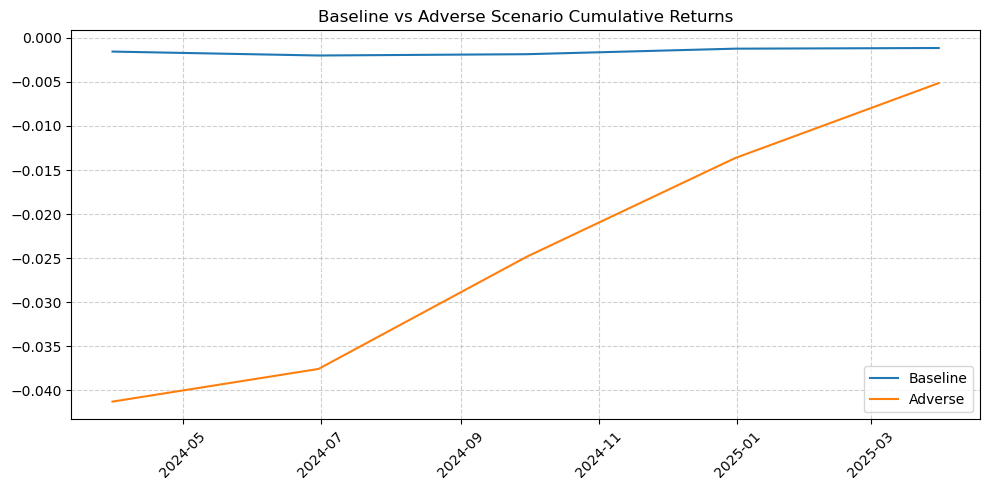

In [79]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

axes.plot(final_merge.index, 
          final_merge['Predicted Returns_x'], label='Baseline')
axes.plot(final_merge.index, 
          final_merge['Predicted Returns_y'], label='Adverse')
axes.set_title("Baseline vs Adverse Scenario Cumulative Returns")
axes.legend()
axes.grid(True, linestyle='--', alpha=0.6)
axes.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [80]:
fig_regression_results = pd.read_csv("fig_regression_results.csv")

fig_regression_results.set_index('Unnamed: 0', inplace=True)
fig_regression_results.index = pd.to_datetime(fig_regression_results.index)

In [81]:
final_merge['Cumulative Returns - Baseline'] = 2.118593 + (final_merge['Predicted Returns_x']).cumsum()
final_merge['Cumulative Returns - Adverse'] = 2.118593 + (final_merge['Predicted Returns_y']).cumsum()

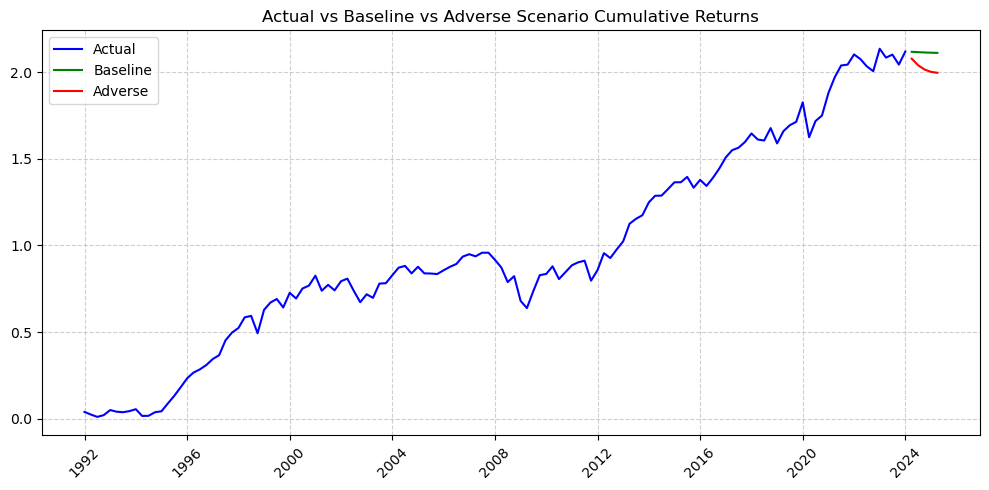

In [82]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

# Plot actual cumulative returns
axes.plot(fig_regression_results.index, 
          fig_regression_results['Cumulative Actual Returns'], label='Actual', color='blue')

# Plot baseline scenario cumulative returns
axes.plot(final_merge.index, 
          final_merge['Cumulative Returns - Baseline'], label='Baseline', color='green')

# Plot adverse scenario cumulative returns
axes.plot(final_merge.index, 
          final_merge['Cumulative Returns - Adverse'], label='Adverse', color='red')

axes.set_title("Actual vs Baseline vs Adverse Scenario Cumulative Returns")
axes.legend()
axes.grid(True, linestyle='--', alpha=0.6)
axes.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Section 4.6 Projecting Error Bands

To provide error bands for the projections, we can estimate the variance of each predicted return and use it to construct confidence intervals around the cumulative returns. Specifically, the variance of a return can incorporate the residual variance from the calibration stage and the influence of MEV forecasts, adjusted by the inverse of the historical data covariance matrix. The cumulative return forecasts can then be adjusted by adding and subtracting the standard deviation of the cumulative variance to generate upper and lower bounds. These bounds, can represent a one-standard-deviation range and provide a conceptual method to visualize uncertainty and assess the robustness of projections.
